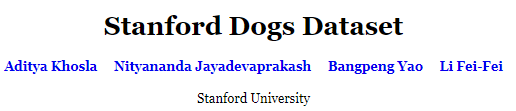

# Contexte

Je suis bénévole pour l'association de protection des animaux de mon quartier, Le Refuge. <br/>
L'association aurait besoin d'aide pour mettre à jour sa base de données de pensionnaires.<br/>
L'objectif de ce projet est de leur proposer un algorithme capable de classer les images en fonction de la race du chien présent sur l'image.<br/>

Les étapes que nous allons suivre :<br/>
- **Pré-processer les images** avec des techniques spécifiques *(e.g. whitening, equalization, éventuellement modification de la taille des images)*.<br/>
- Réaliser une **data augmentation** *(mirroring, cropping...)*.<br/>
- Mettre en oeuvre de 2 approches de CNN :<br/>
    - Réaliser notre propre réseau de neurones CNN en optimisant les paramètres.   <br/>  
    - Utiliser le transfert learning.<br/>

**Données disponibles** :<br/>
Un repo Git est disponible pour ce projet à l'adreshttps://github.com/JustineJa/OC_IML_P6n<br/>
Les données sources pour entraîner notre modèle se trouvent ici : http://vision.stanford.edu/aditya86/ImageNetDogs/..com/

<h1><span style="color:#343434" id="sommaire">Sommaire</span></h1>

1. [Preprocessing des images](#section_1)     
    1.1. [Visualisation de la liste des races (classes) et un exemple de données](#section_1_1)     
    1.2. [Modification de la taille des images](#section_1_2)     
    1.3. [Modification des histogrammes des images](#section_1_3)      
    1.4. [Application de filtres](#section_1_4)      
    1.5. [Augmentation de données](#section_1_5)      
    1.6. [Fonction de traitement par lot pour le preprocessing](#section_1_6)      

In [1]:
# Import libraries
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import timeit
import cv2 as cv

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
#from tensorflow.keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as K
#import kerastuner as kt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
warnings.filterwarnings('ignore')

In [3]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

GPU device not found
Found GPU at: 


# <span style="color:#343434" id="section_1">1. Preprocessing des images</span>

Tout d'abord, nous allons rapidement analyser les données :

## <span style="color:#343434" id="section_1_1">1.1. Visualisation de la liste des races *(nos classes)* et un exemple de données.</span>

In [4]:
# Define path to data
annotations_dir = 'C:/Users/A475388/Repo_Github/OC_IML_P6/data/Annotation' 
images_dir = 'C:/Users/A475388/Repo_Github/OC_IML_P6/data/Images'

In [5]:
# Count the number of classes (dogs breeds)
list_races = os.listdir(images_dir)
print(f"Il y a {len(list_races)} races dans le dataset")

Il y a 120 races dans le dataset


120 races de chien sont donc présentes dans notre jeu de données, ce qui représente **120 classes**.<br/>
Nous allons compter le nombre d'images par race pour contrôler la distribution :

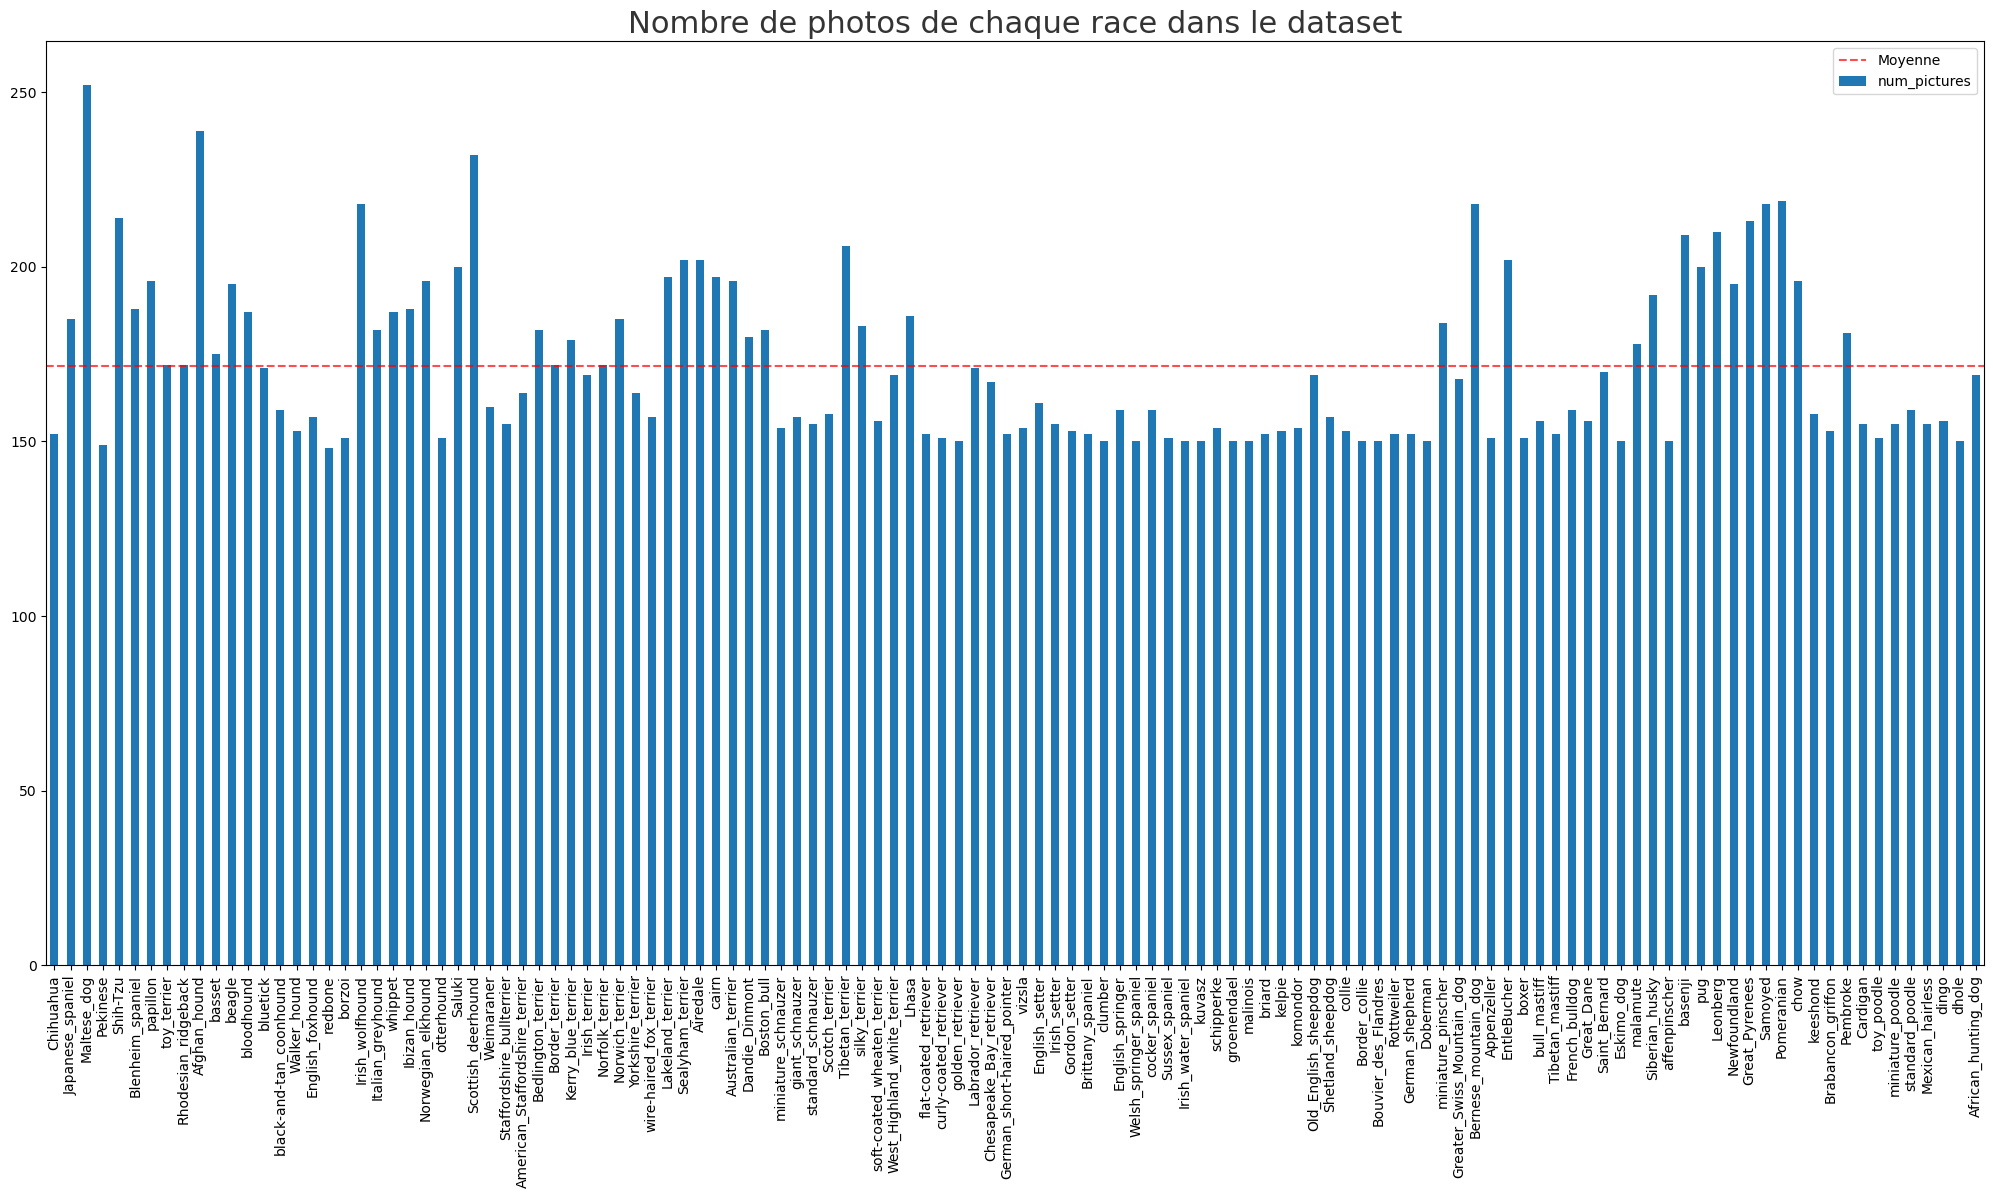

In [6]:
# Count number of pictures for each breed
df_races = pd.DataFrame(
    index=[race.split('-',1)[1]
           for race in list_races],
    data=[len(os.listdir(images_dir + "/" + name))
          for name in list_races],
    columns=["num_pictures"])

# Plot results
fig, ax = plt.subplots(1, 1, figsize=(25,12))
df_races.plot(kind="bar",
               legend=False,
               ax=ax)
ax.axhline(df_races["num_pictures"].mean(),
           color='r', alpha=.7,
           linestyle='--',
           label="Moyenne")
plt.title("Nombre de photos de chaque "\
          "race dans le dataset",
          color="#343434", fontsize=22)
plt.legend()
plt.show()

Les races de chien sont toutes bien alimentées en images. 

**Regardons quelques exemples des photos par races** disponibles dans la base d'étude :

In [7]:
def show_images_classes(path, classes, num_sample):
    """This function is used to display the first 
    n images of a directory passed as an argument. 
    It is adapted to subdirectories. 
    
    The matplotlib.image library must be loaded 
    with the alias mpimg. 

    Parameters
    ----------------------------------------
    path : string
        Link of root directory
    classes : string 
        Name of the subdirectory
    num_smaple : integer
        Number of picture to show
    ----------------------------------------
    """
    fig = plt.figure(figsize=(20,20))
    fig.patch.set_facecolor('#343434')
    plt.suptitle("{}".format(classes.split("-")[1]), y=.83,
                 color="white", fontsize=22)
    images = os.listdir(path + "/" + classes)[:num_sample]
    for i in range(num_sample):
        img = mpimg.imread(path+"/"+classes+"/"+images[i])
        plt.subplot(num_sample+1, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

Nous allons conserver les 4 races les plus "fournies" en photos + les bulledogs français : 

In [8]:
df_races.sort_values(by = 'num_pictures', ascending = False).head(5)

num_pictures
Maltese_dog                    252
Afghan_hound                   239
Scottish_deerhound             232
Pomeranian                     219
Bernese_mountain_dog           218

In [9]:
list_races = ['n02085936-Maltese_dog', 'n02088094-Afghan_hound', 
              'n02092002-Scottish_deerhound', 'n02112018-Pomeranian', 'n02108915-French_bulldog']

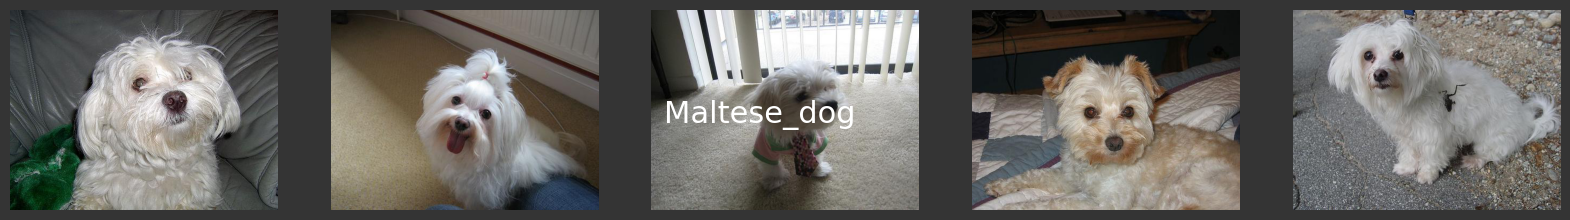

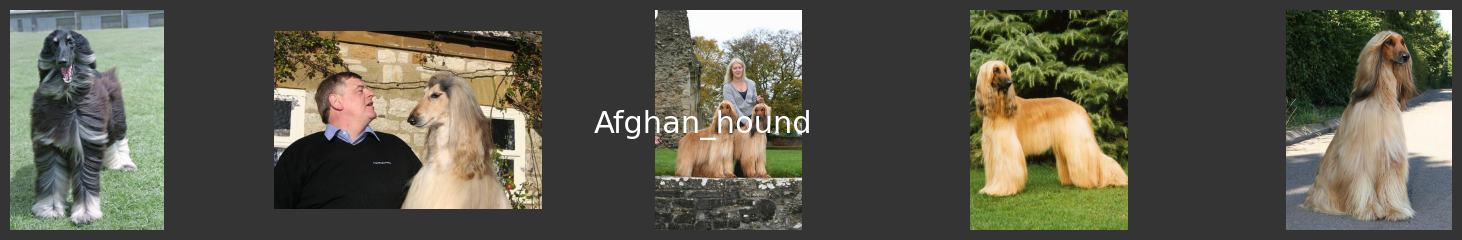

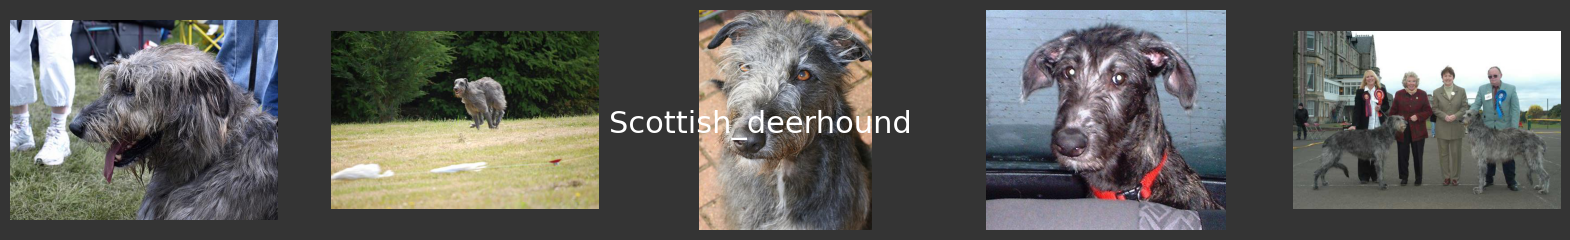

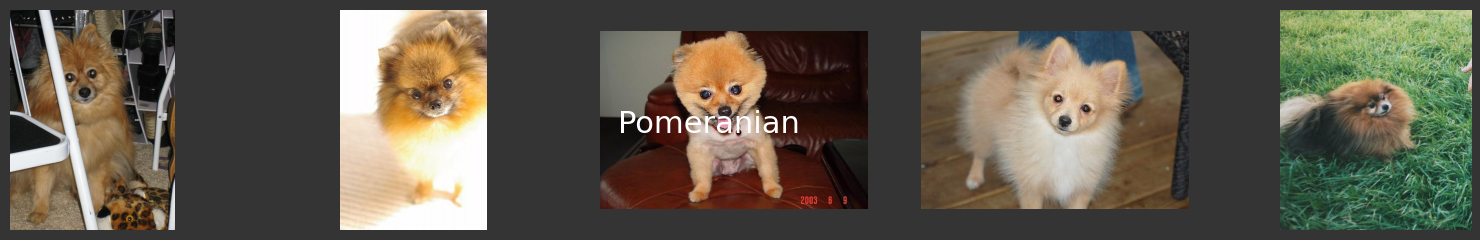

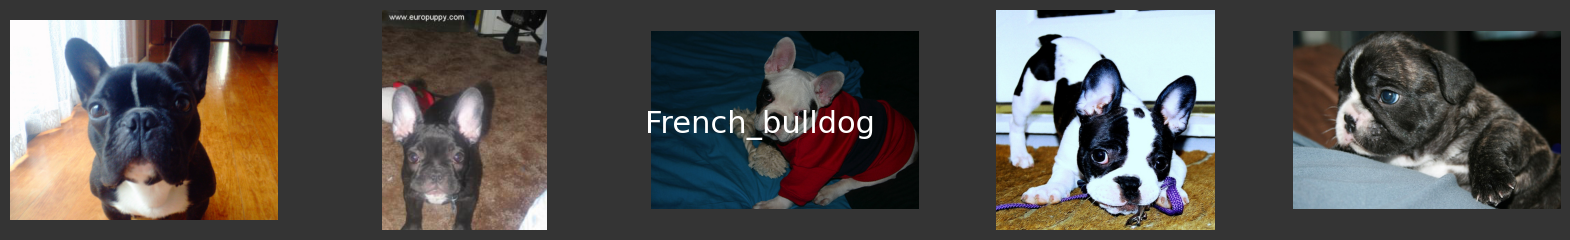

In [10]:
for i in list_races:
    show_images_classes(images_dir, i, 5)

Nous allons devoir **modifier la taille des images** pour qu'elles s'adaptent aux contraintes du modèle CNN de transfert learning. Cela aura également pour effet de diminuer les temps de calculs de notre modèle propre.

## <span style="color:#343434" id="section_1_2">1.2. Action sur les photos</span>

On peut remarquer dans les images en exemple ci-dessus que :
- les chiens présents sur les photos ne sont pas toujours au centre de la photo,
- les expositions, contraste, ... sont différents
- les zooms sont différents...<br/>

Redimensionner les images ne va pas changer ces attributs, **l'image va même être déformée** pour coller au nouvelles dimensions.

Nous allons réaliser la transformation sur une image test pour commencer.

In [11]:
# Define test image
img_test = (images_dir 
            + "/" 
            + "n02085782-Japanese_spaniel/n02085782_1626.jpg")
img_test = cv.imread(img_test)

In [12]:
# Define test image
img_test = "oslo.png"
img_test = cv.imread(img_test)

In [13]:
print(f"Largeur : {img_test.shape[0]} px, hauteur : {img_test.shape[1]} px")

Largeur : 1600 px, hauteur : 1200 px


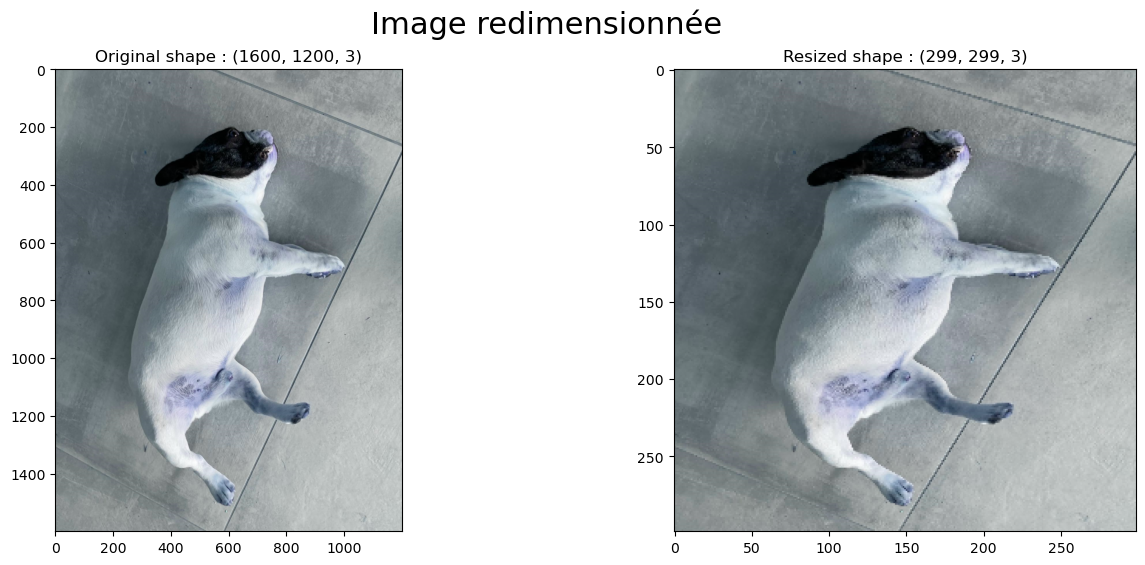

In [14]:
# setting dim of the resize
height = 299
width = 299
dim = (width, height)
# resize image with OpenCV
res_img = cv.resize(img_test, dim, interpolation=cv.INTER_LINEAR)

# Show both img
fig = plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.imshow(img_test)
plt.title("Original shape : {}".format(img_test.shape))
plt.subplot(1, 2, 2)
plt.imshow(res_img)
plt.title("Resized shape : {}".format(res_img.shape))
plt.suptitle("Image redimensionnée",
             color="black", 
             fontsize=22, y=.98)
plt.show()

On voit bien ici que le redimensionnement en 299 x 299 déforme la photo initiale. **Une fois ce filtre appliqué à toutes les images, elles seront probablement toutes déformées**.

Nous allons à présent utiliser des méthodes basées sur les histogrammes de ces images pour pre-processer au mieux ces données.

## <span style="color:#343434" id="section_1_3">1.3. Modification de l'histogramme des images</span>

L'histogramme d'une image numérique est une courbe statistique représentant la **répartition de ses pixels selon leur intensité**. 

Nous allons transformer l'image dans différents codages couleurs. Le système de codage **YUV** est créé depuis une source RVB. Il est codé en trois composantes : **Y** représente la luminance *(informations de luminosité)* tandis que les deux autres (**U** et **V**) sont des données de chrominance *(informations de couleur)*. Ce format nous permet de visualiser au mieux l'histogramme pour les 3 dimensions :

### Def

In [15]:
def RGBStats(image): 
    colors = [] 
    for i in range(0, 3): 
        max_color =np.max(image[:,:,i]) 
        min_color =np.min(image[:,:,i]) 
        mean_color = np.mean(image[:,:,i]) 
        median_color = np.median(image[:,:,i]) 
        row = (min_color, max_color, mean_color, median_color)
        colors.append(row)
    return pd.DataFrame(colors,  
                        index = ['Red', ' Green', 'Blue'], 
                        columns = ['Min', 'Max', 'Mean', 'Median'])

In [16]:
def imageHist(image):
    _, axis = plt.subplots(ncols=2, figsize=(12, 3))
    if (image.ndim == 2):
        # Grascale Image
        axis[0].imshow(image, cmap=plt.get_cmap('gray'))
        axis[1].set_title('Histogram')
        axis[0].set_title('Grayscale Image')
        hist = exposure.histogram(image)
        axis[1].plot(hist[0])
    else:
        # Color image
        axis[0].imshow(image, cmap='gray')
        axis[1].set_title('Histogram')
        axis[0].set_title('Colored Image')
        rgbcolors = ['red', 'green', 'blue']
        for i, mycolor in enumerate(rgbcolors):
            axis[1].plot(exposure.histogram(image[...,i])[0], color=mycolor)

In [17]:
# Create histogram
def plot_histogram(init_img, convert_img):
    """Function allowing to display the initial
    and converted images according to a certain
    colorimetric format as well as the histogram
    of the latter. 

    Parameters
    -------------------------------------------
    init_img : list
        init_img[0] = Title of the init image
        init_img[1] = Init openCV image
    convert_img : list
        convert_img[0] = Title of the converted
        convert_img[1] = converted openCV image
    -------------------------------------------
    """
    hist, bins = np.histogram(
                    convert_img[1].flatten(),
                    256, [0,256])
    # Cumulative Distribution Function
    cdf = hist.cumsum()
    cdf_normalized = cdf * float(hist.max()) / cdf.max()

    # Plot histogram
    fig = plt.figure(figsize=(25,6))
    plt.subplot(1, 3, 1)
    plt.imshow(init_img[1])
    plt.title("{} Image".format(init_img[0]), 
              color="#343434")
    plt.subplot(1, 3, 2)
    plt.imshow(convert_img[1])
    plt.title("{} Image".format(convert_img[0]), 
              color="#343434")
    plt.subplot(1, 3, 3)
    plt.plot(cdf_normalized, 
             color='r', alpha=.7,
             linestyle='--')
    plt.hist(convert_img[1].flatten(),256,[0,256])
    plt.xlim([0,256])
    plt.legend(('cdf','histogram'), loc = 'upper left')
    plt.title("Histogramme de l'image convertie", color="#343434")
    #plt.suptitle("Histogram and cumulative "\
    #             "distribution for test image",
    #          color="black", fontsize=22, y=.98)
    plt.show()

### Tests

In [18]:
RGBStats(img_test)

Min  Max        Mean  Median
Red       0  255  135.670354   138.0
 Green    0  255  144.170320   146.0
Blue      0  255  147.927423   149.0

In [19]:
# Transform image with differents color sets
img_RGB = cv.cvtColor(img_test, cv.COLOR_BGR2RGB)
img_grayscale = cv.cvtColor(img_test, cv.COLOR_RGB2GRAY)
img_YUV = cv.cvtColor(img_test,cv.COLOR_BGR2YUV)

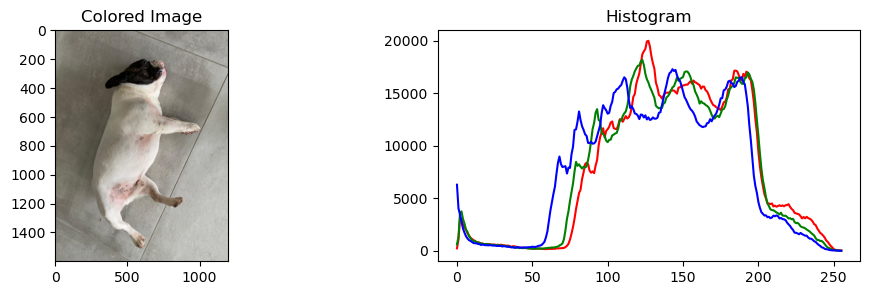

In [20]:
from skimage.io import imread, imshow
from skimage import exposure
image1 = imread("oslo.png") #, as_gray=True)
imageHist(image1)

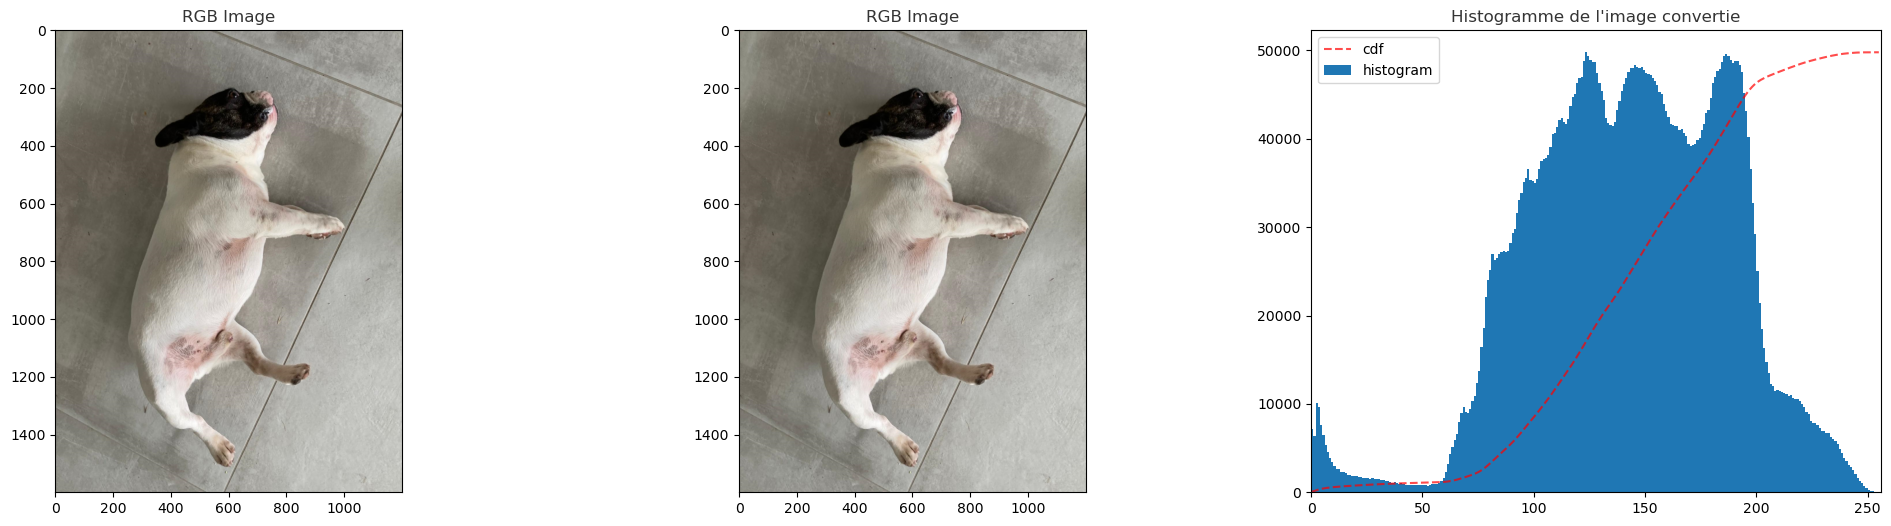

In [21]:
plot_histogram(["RGB", img_RGB], ["RGB", img_RGB])

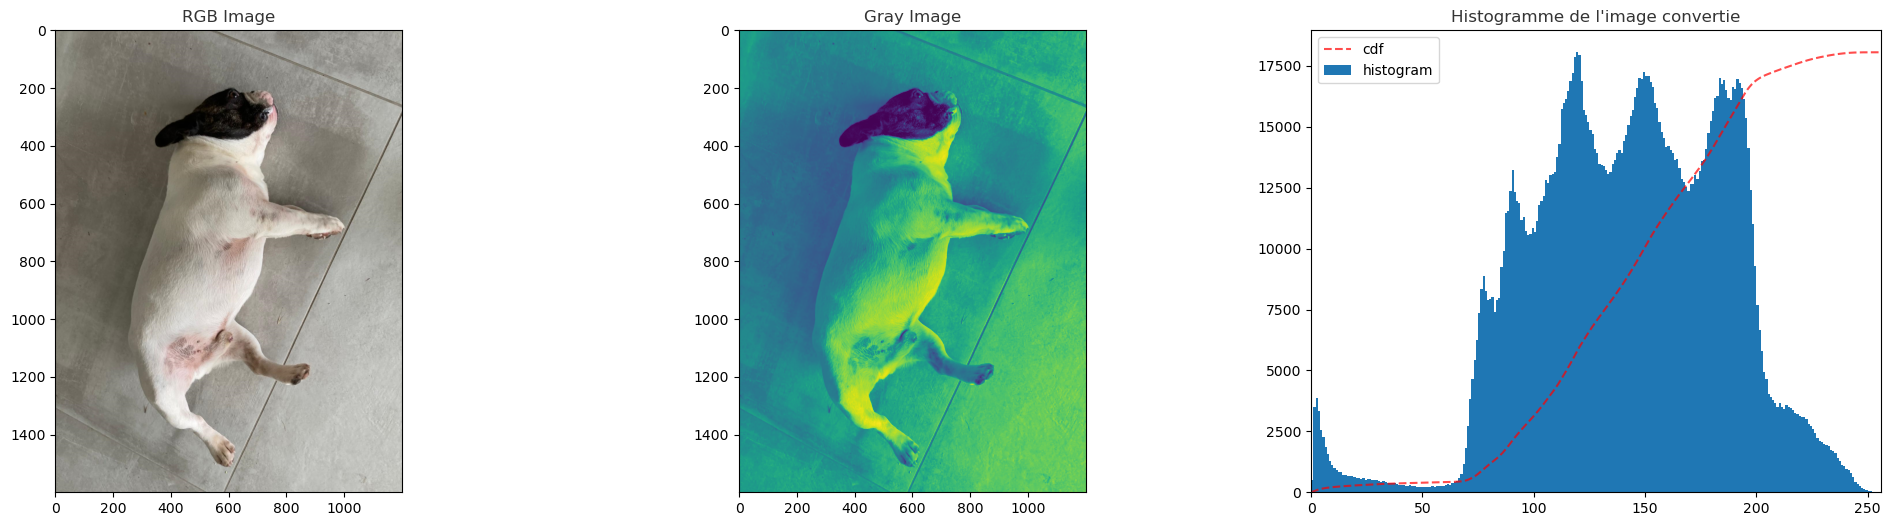

In [22]:
plot_histogram(["RGB", img_RGB], ["Gray", img_grayscale])

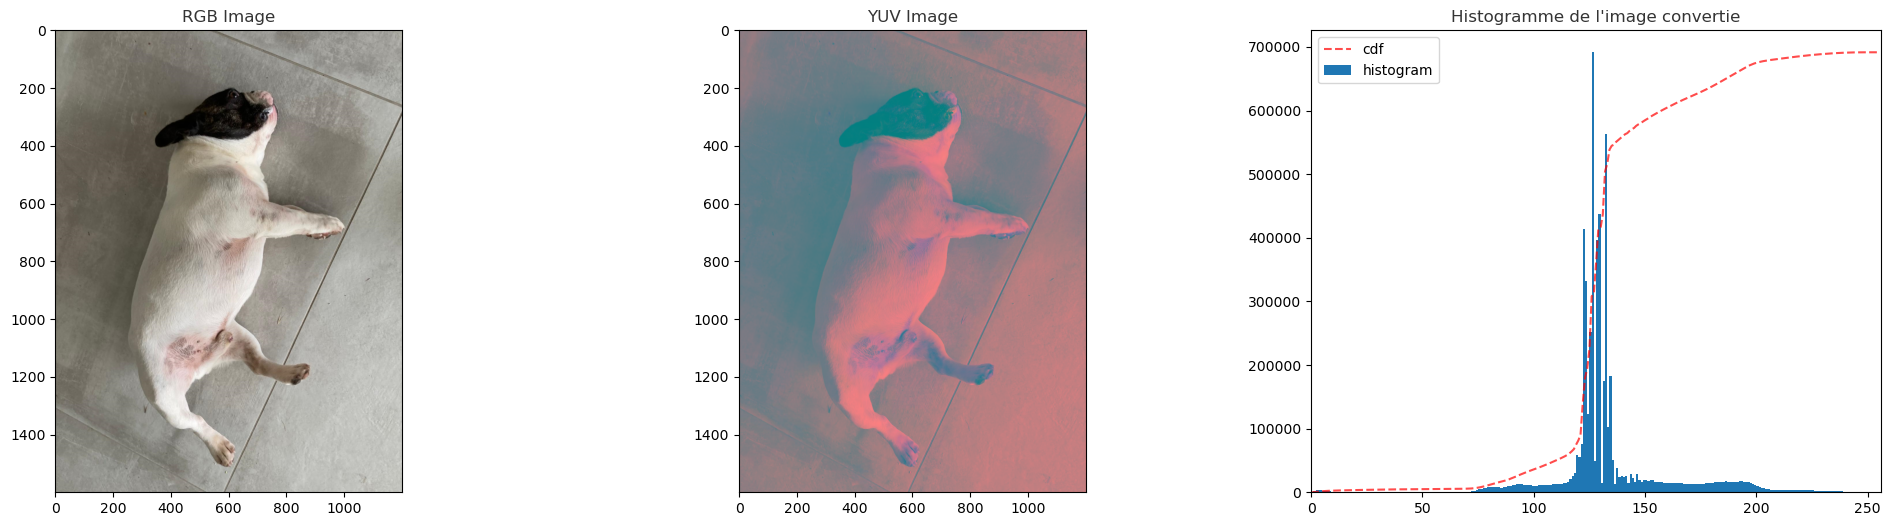

In [23]:
plot_histogram(["RGB", img_RGB], ["YUV", img_YUV])

In [24]:
# Récupérer les valeurs de tous les pixels sous forme d'une matrice
mat = np.array(img_test)

# Afficher la taille de la matrice de pixels
print("Taille de la matrice de pixels : {}".format(mat.shape))

Taille de la matrice de pixels : (1600, 1200, 3)


In [25]:
mat.shape

(1600, 1200, 3)

### Egalisation

On constate ici des pics importants au centre de l'histogram. Dans le cadre d'une bonne égalisation (amélioration du contraste), il est nécessaire de répartir la lumière dans tout le spectre de l'image. 

**Egalisation avec OpenCV :**     
L'intérêt de convertir l'image dans l'espace colorimétrique YUV est de pouvoir agir sur le canal "luminance" (Y) indépendamment des autres canaux de chrominance. Nous allons donc réaliser l'égalisation sur ce seul canal Y :

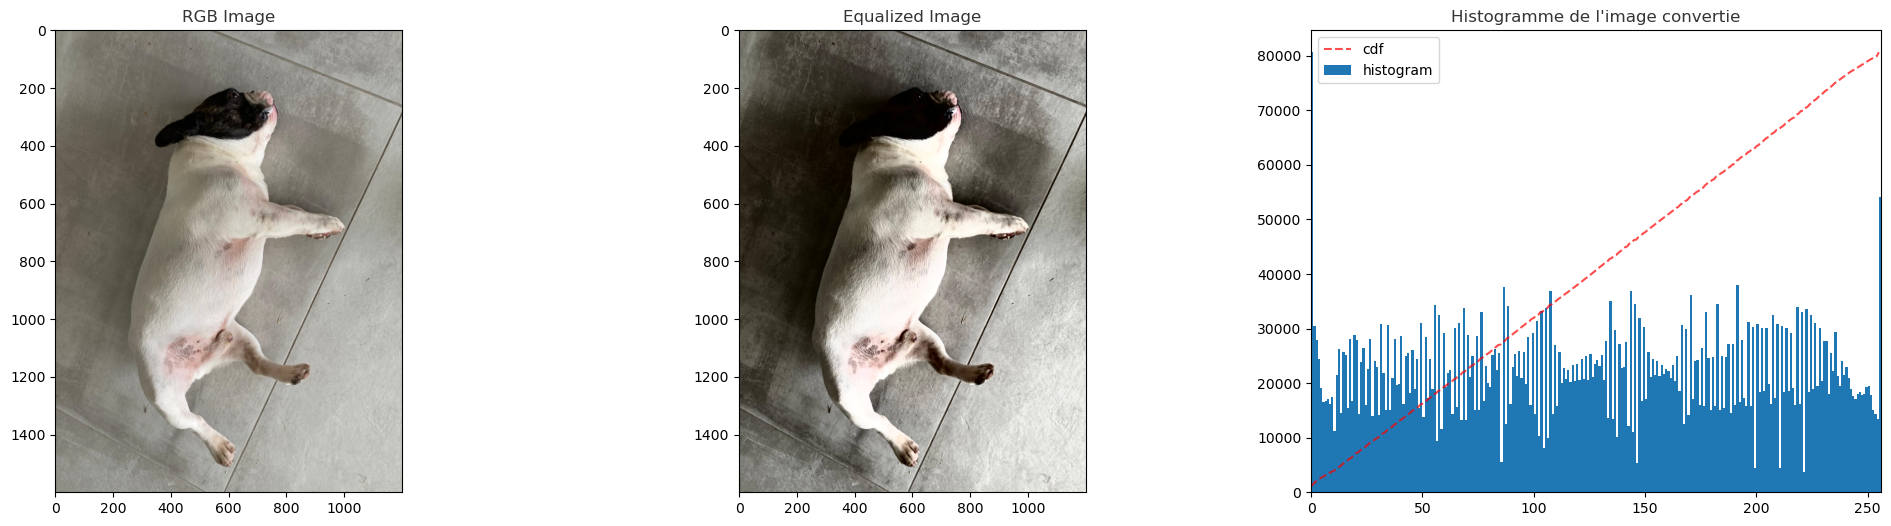

In [26]:
# Equalization
img_YUV[:,:,0] = cv.equalizeHist(img_YUV[:,:,0])
img_equ = cv.cvtColor(img_YUV, cv.COLOR_YUV2RGB)
plot_histogram(["RGB", img_RGB], ["Equalized", img_equ])

L'image résultante est donc bien égualisée, l'histogramme couvre l'ensemble du spectre et la CDF est constante et linéaire. **Ce pré-traitement sera donc appliqué à l'ensemble des images**.

## <span style="color:#343434" id="section_1_4">1.4. Application de filtres</span>
Les images peuvent pour de nombreuses raisons être bruitées, c'est à dire comporter des pixels atypiques qui peuvent fausser la détection de features. Par exemple de causes de bruits :
* Caractéristiques de l'appareil photo,
* Compression des images JPEG
* Mauvaise résolution ...

Pour pallier au bruit présent dans les images, il est possible d'appliquer un filtre. Il en existe de plusieurs types : les filtres linéaires (comme le filtre Gaussien), non linéaires comme le filtre médian par exemple.      
un des meilleurs filtre pour débruiter l'image est le **filtre non-local means**.


### Filtre non-local means
Contrairement aux filtres « moyenne locale », qui prennent la valeur moyenne d'un groupe de pixels entourant un pixel cible pour lisser l'image, le filtrage des moyennes non locales prend une moyenne de **tous les pixels de l'image**, pondérée par la similarité de ces pixels avec le pixel cible. Cela se traduit par une clarté de post-filtrage beaucoup plus grande et moins de perte de détails dans l'image par rapport aux algorithmes de moyenne locale.

Testons ce fitre sur notre image test :

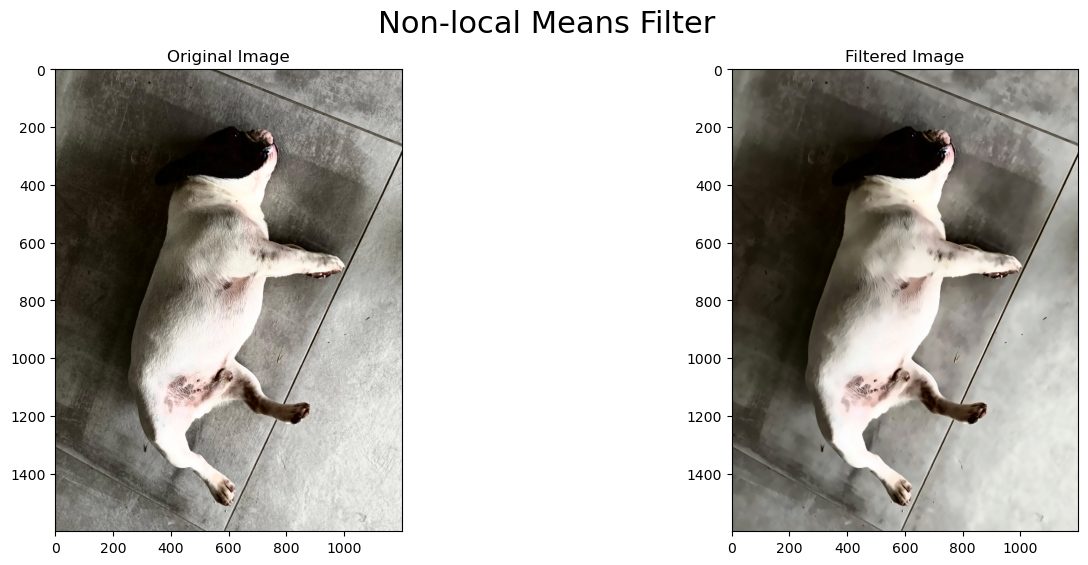

In [27]:
# Apply non-local means filter on test img
dst_img = cv.fastNlMeansDenoisingColored(
    src=img_equ,
    dst=None,
    h=10,
    hColor=10,
    templateWindowSize=7,
    searchWindowSize=21)

# Show both img
fig = plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.imshow(img_equ)
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(dst_img)
plt.title("Filtered Image")
plt.suptitle("Non-local Means Filter",
             color="black", 
             fontsize=22, y=.98)
plt.show()

## <span style="color:#343434" id="section_1_5">1.5. Augmentation de données</span>

Le risque sur ce type de dataset comportant peu de données (20 000 images) est de sur-entrainer notre modèle, il ne pourra pas développer des règles de décisions pouvant être généralisé à de nouvelles données. Il faut donc augmenter le nombre de data et pour cela, nous allons utiliser la **Data Augmentation**.

L'objectif de la data augmentation est de reproduire les images préexistantes en leur appliquant une **transformation aléatoire**. Pour cela, Keras mets à disposition la méthode `ImageDataGenerator` qui permet de faire à la fois du mirroring, de la rotation, des zoom ... et ce de manière aléatoire !

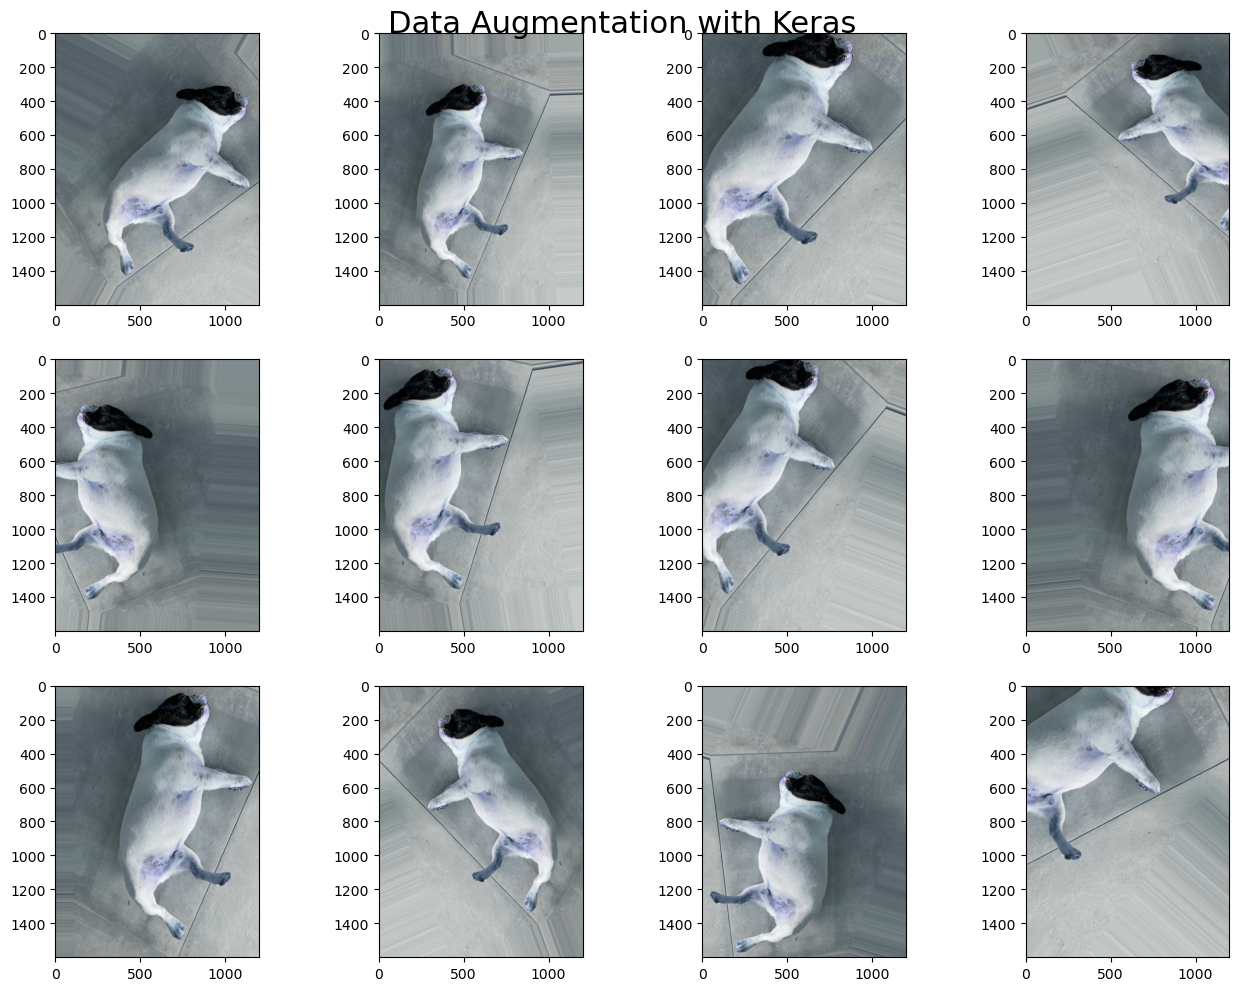

In [28]:
#Initilize Data Generator Keras
augmented_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Convert test img to array
x = image.img_to_array(img_test)
x = x.reshape((1,) + x.shape)

i=0
fig = plt.figure(figsize=(16,12))
for batch in augmented_datagen.flow(x, batch_size=1):
    ax = fig.add_subplot(3,4,i+1)
    ax.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 12 == 0:
        break

plt.suptitle("Data Augmentation with Keras",
             color="black", 
             fontsize=22, y=.90)
plt.show()


## Whitening transformation
**Improving Model Training:**<br/>
When training machine learning models (e.g., neural networks), using whitened images can improve convergence and model performance. It ensures that the input features have similar scales and are centered around zero.

In [29]:
def image_whitening(image):
    # Flatten the image to (n*m, 3)
    flattened_image = image.reshape(-1, 3)

    # Compute the mean and standard deviation for each channel
    channel_means = np.mean(flattened_image, axis=0)
    channel_stds = np.std(flattened_image, axis=0)

    # Whitening transformation
    whitened_image = (flattened_image - channel_means) / channel_stds

    # Reshape back to original shape
    whitened_image = whitened_image.reshape(image.shape)

    return whitened_image

# Example usage:
# Assuming you have an image 'color_image' of shape (n, m, 3)
# Call the function to perform whitening
whitened_image = image_whitening(img_test)

# Print a success message
print("Image whitening completed.")

Image whitening completed.


In [30]:
# Récupérer les valeurs de tous les pixels sous forme d'une matrice
mat = np.array(img_test)

# Afficher la taille de la matrice de pixels
print(f"Taille de la matrice de pixels : {mat.shape}")

Taille de la matrice de pixels : (1600, 1200, 3)


La méthode de Data Augmentation nous permet d'obtenir des images avec différents zoom, des effets mirroir et des rotations qui vont donc augmenter notre base d'images.

## <span style="color:#343434" id="section_1_6">1.6. Fonction de traitement par lot pour le preprocessing</span>

Nous allons déjà tester les fonctions et la classification sur un nombre restreint de race de chien afin de limiter les temps de calcul. Constuisons la fonction de preprocessing qui retournera les labels et images :

In [31]:
def preprocessing_cnn(directories, img_width, img_height):
    """Preprocessing of images in order to integrate them 
    into a convolutional neural network. Equalization, 
    Denoising and transformation of the image into Array. 
    Simultaneous creation of labels (y). 

    Parameters
    ---------------------------------------------------
    directoriesList : list
        List of files to be processed.
    img_width : integer
        width of the image to be reached for resizing
    img_height : integer
        height of the image to be reached for resizing
    ---------------------------------------------------
    """
    img_list=[]
    labels=[]
    for index, breed in enumerate(directories):
        for image_name in os.listdir(images_dir+"/"+breed):
            # Read image
            img = cv.imread(images_dir+"/"+breed+"/"+image_name)
            img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
            # Resize image
            dim = (img_width, img_height)
            img = cv.resize(img, dim, interpolation=cv.INTER_LINEAR)
            # Equalization
            img_yuv = cv.cvtColor(img,cv.COLOR_BGR2YUV)
            img_yuv[:,:,0] = cv.equalizeHist(img_yuv[:,:,0])
            img_equ = cv.cvtColor(img_yuv, cv.COLOR_YUV2RGB)
            # Apply non-local means filter on test img
            dst_img = cv.fastNlMeansDenoisingColored(
                src=img_equ,
                dst=None,
                h=10,
                hColor=10,
                templateWindowSize=7,
                searchWindowSize=21)

            # Whitening transformation
            whitened_image = dst_img
            #whitened_image = image_whitening(dst_img)
            
            
            # Convert modified img to array
            img_array = image.img_to_array(whitened_image)
            
            # Append lists of labels and images
            img_list.append(np.array(img_array))
            labels.append(breed.split("-")[1])
    
    return img_list, labels

Nous allons créer et entrainer les modèles sur **5 races de chiens**. 

Cet algorithme pourra ensuite être étendu à l'ensemble des races s'il est satisfaisant.

In [32]:
# Define numbers of breeds to preprocess
nb_races = len(list_races) 
# Execute preprocessor on selection
start_time = timeit.default_timer()
# X = images
# y = labels
X, y = preprocessing_cnn(list_races, 299, 299)
# Convert in numpy array
X = np.array(X)
y = np.array(y)
preprocess_time = timeit.default_timer() - start_time

print("-" * 50)
print("Nombre d'images préprocessées : {}"\
     .format(len(y)))
print("Taille des images np.array : {}"\
     .format(X.shape))
print("Temps total : {:.2f}s".format(preprocess_time))

--------------------------------------------------
Nombre d'images préprocessées : 1101
Taille des images np.array : (1101, 299, 299, 3)
Temps total : 512.97s


In [33]:
y[1000]

'French_bulldog'

In [34]:
list_races

['n02085936-Maltese_dog',
 'n02088094-Afghan_hound',
 'n02092002-Scottish_deerhound',
 'n02112018-Pomeranian',
 'n02108915-French_bulldog']

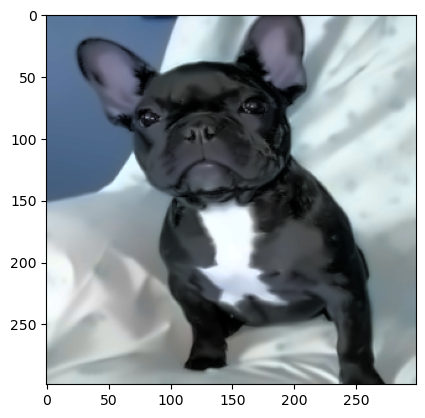

In [35]:
# Show exemple preprocessed image
plt.imshow(image.array_to_img(X[1000]))

## Analyse 2D

# <span style="color:#343434" id="section_2">2. Modèle CNN à construire</span>

## <span style="color:#343434" id="section_2_1">2.1. Préparation des données</span>
Mélanger les images pour que les photos de même race ne se suivent.

In [36]:
# Using np.shuffle
img_space = np.arange(X.shape[0])
np.random.seed(8)
# Shuffle the space
np.random.shuffle(img_space)
# Apply to X and y in same order
X = X[img_space]
y = y[img_space]

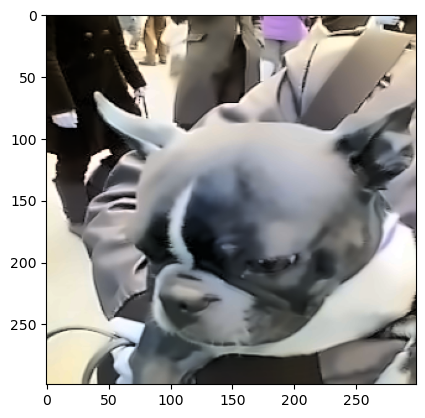

In [37]:
# Show exemple preprocessed image
plt.imshow(image.array_to_img(X[1000]))

**Préparation des données pour l'input dans keras :** 
- X -> float
- y -> encodage numérique des donnéees textuelles (races de chien) => LabelEncoder

In [38]:
X.shape

(1101, 299, 299, 3)

In [39]:
# Change X type 
#X = X.astype(np.float32)
# Encode y text data in numeric
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

In [40]:
# Verifie encoder created classes
print(encoder.classes_)

['Afghan_hound' 'French_bulldog' 'Maltese_dog' 'Pomeranian'
 'Scottish_deerhound']


In [41]:
mylist2 = set(y)
mylist2 = list(mylist2)
print(mylist2)

[0, 1, 2, 3, 4]


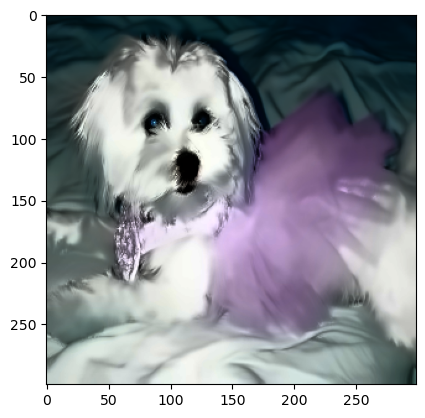

In [42]:
# Show exemple preprocessed image
plt.imshow(image.array_to_img(X[500]))

In [43]:
y[500]

2

Création set **entraînement et validation**. 

Le set de **validation** quant à lui sera créé dans le générateur Keras.

In [44]:
### Create train and test set
# Split data into training (80%), testing (10%), and validation (10%) sets
x_train, x_temp, y_train, y_temp = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y
                                                   )
x_test, x_val, y_test, y_val = train_test_split(x_temp, 
                                                y_temp, 
                                                test_size=0.5, 
                                                random_state=42, 
                                                stratify=y_temp
                                               )

print("-" * 50)
print("Taille des sets :")
print("-" * 50)
print("Train set = ",x_train.shape[0])
print("Test set = ",x_test.shape[0])
print("Validation set = ",x_val.shape[0])

--------------------------------------------------
Taille des sets :
--------------------------------------------------
Train set =  880
Test set =  110
Validation set =  111


Dernière étape de la préparation, nous allons **créer les générateurs Keras** pour les sets de données en incluant la **Data Augmentation pour le jeu d'entrainement** :

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [45]:
# Data generator on train set with Data Augmentation
# Validation set is define here
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)

#For validation and test, just rescale
test_datagen = ImageDataGenerator(rescale=1./255)

## <span style="color:#343434" id="section_2_2">2.2. Construction du modèle CNN</span>

In [46]:
train_datagen.fit(x_train)

In [47]:
height = X.shape[1]
width = X.shape[2]
num_classes = nb_races

# Define the model
model = Sequential()

# Input layer and first convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(height, width, 3)))  # height and width should be set based on your data
model.add(MaxPooling2D((2, 2)))

# Second convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Third convolutional layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten the output of the convolutional layers
model.add(Flatten())

# First fully connected layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Optional: Dropout for regularization

# Second fully connected layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))  # Optional: Dropout for regularization

# Third fully connected layer
model.add(Dense(32, activation='relu'))

# Output layer with softmax activation for classification
model.add(Dense(num_classes, activation='softmax'))  # num_classes should be set based on the number of classes in your problem

Ajoute la condition d'early stopping :

In [48]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [49]:
# https://www.tensorflow.org/api_docs/python/tf/keras/Model
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use 'sparse_categorical_crossentropy' if labels are integers
              metrics=['accuracy'])

In [50]:
# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 297, 297, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 148, 148, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 146, 146, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 73, 73, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 71, 71, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 35, 35, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 156800)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      20,070,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,174,277 (76.96 MB)

 Trainable params: 20,174,277 (76.96 MB)

 Non-trainable params: 0 (0.00 B)

Notre modèle est créé, nous allons pouvoir l'**entrainer sur 50 époques grâce aux générateur précédement créés et stocker les résultats** pour ensuite les analyser :

## <span style="color:#343434" id="section_2_3">2.3. Entrainement et évaluation du modèle CNN</span>

In [51]:
history = model.fit(train_datagen.flow(x_train, y_train, batch_size=32),
                    steps_per_epoch=len(x_train) // 32,
                    epochs=10,
                    validation_data=(x_val, y_val),
                   #callbacks=[early_stop]
                   )

Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 522ms/step - accuracy: 0.1984 - loss: 2.0346 - val_accuracy: 0.2072 - val_loss: 7.5861
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2500 - loss: 1.6169 - val_accuracy: 0.2072 - val_loss: 5.0995
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 528ms/step - accuracy: 0.2249 - loss: 1.6085 - val_accuracy: 0.2072 - val_loss: 7.3858
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2188 - loss: 1.6066 - val_accuracy: 0.2072 - val_loss: 2.5371
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 514ms/step - accuracy: 0.2370 - loss: 1.6045 - val_accuracy: 0.2162 - val_loss: 1.8131
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2812 - loss: 1.6022 - val_accuracy: 0.2162 - val_loss: 1.7922
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 523ms/step - accuracy: 0.2204 - loss: 1.6014 - val_accuracy: 0.2252 - val_loss: 2.1144
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2188 - loss: 1.6000 - val_accuracy: 0.

### Evaluation du modèle

In [52]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.1993 - loss: 4.9879
Test accuracy: 0.2091


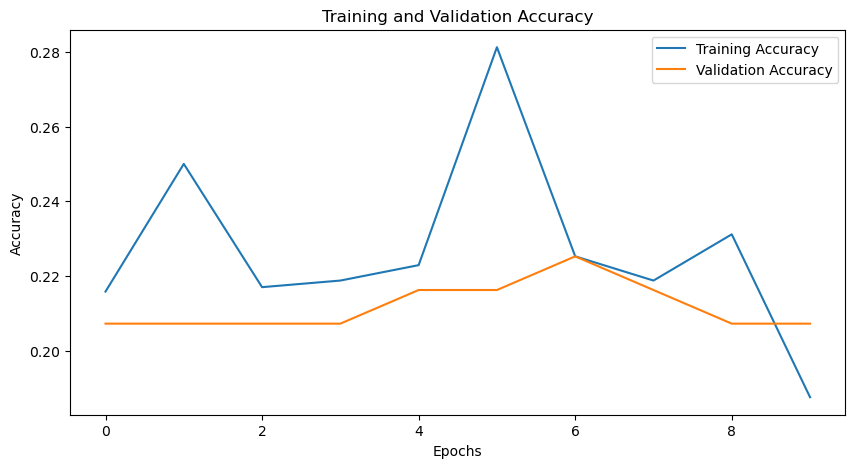

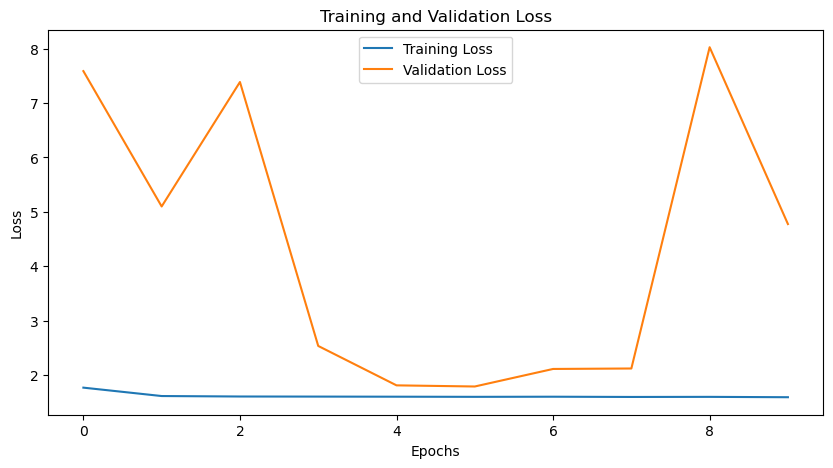

In [53]:
import matplotlib.pyplot as plt

# Assuming you have 'history' from your model training
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

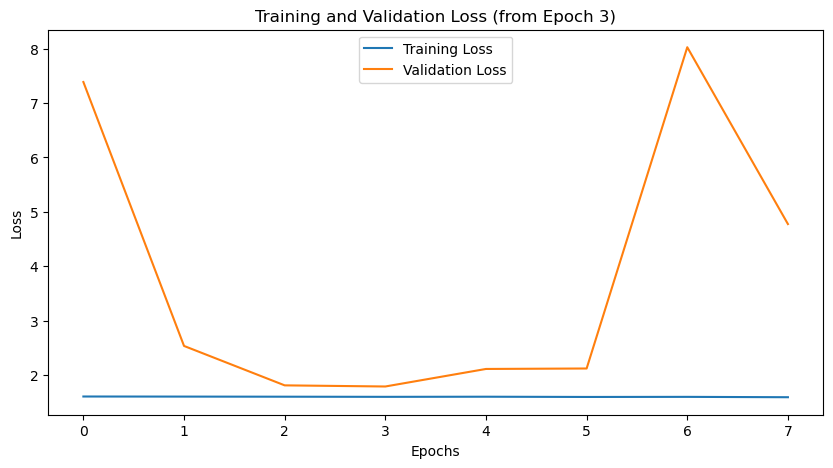

In [54]:
# Assuming you have 'history' from your model training
# Plot training and validation loss for epochs 2 and onwards
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'][2:], label='Training Loss')
plt.plot(history.history['val_loss'][2:], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (from Epoch 3)')
plt.legend()
plt.show()

#### Matrice de confusion

In [55]:
pred = np.argmax(model.predict(x_test), axis=1)
confusion_matrix(y_test, pred)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


array([[ 0,  0,  0,  0, 24],
       [ 0,  0,  0,  0, 16],
       [ 0,  0,  0,  0, 25],
       [ 0,  0,  0,  0, 22],
       [ 0,  0,  0,  0, 23]], dtype=int64)

In [56]:
pd.Series(y_test).value_counts()

2    25
0    24
4    23
3    22
1    16
Name: count, dtype: int64

<Axes: >

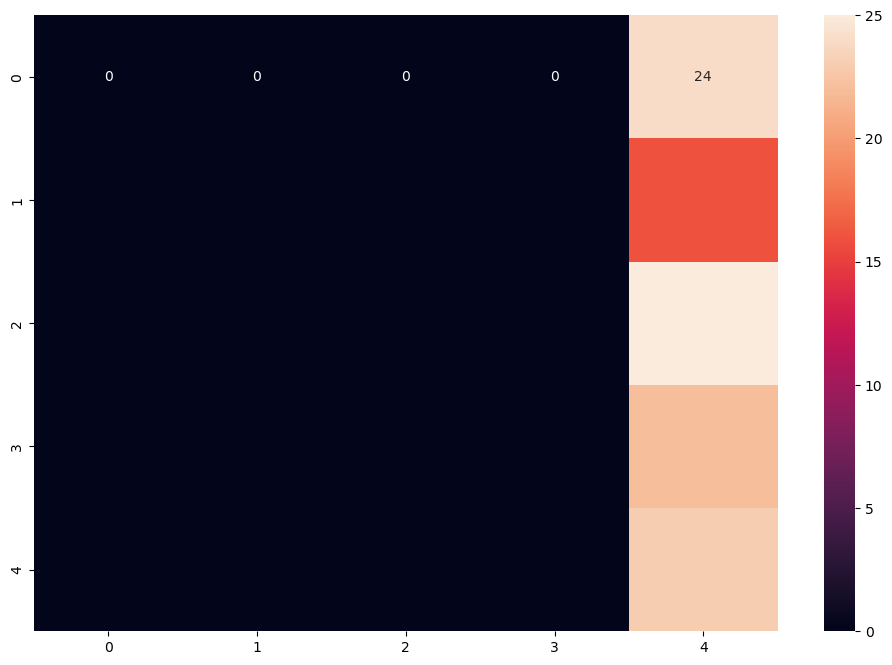

In [57]:
plt.figure(figsize=(12,8))
sns.heatmap(confusion_matrix(y_test, pred),annot=True)

In [58]:
pred

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
      dtype=int64)

## Prediction sur Oslo

In [59]:
img_test = "oslo.png"
img_test = cv.imread(img_test)
# setting dim of the resize
height = 299
width = 299
dim = (width, height)
# resize image with OpenCV
res_img = cv.resize(img_test, dim, interpolation=cv.INTER_LINEAR)

In [60]:
img_YUV = cv.cvtColor(res_img,cv.COLOR_BGR2YUV)
# Equalization
img_YUV[:,:,0] = cv.equalizeHist(img_YUV[:,:,0])
img_equ = cv.cvtColor(img_YUV, cv.COLOR_YUV2RGB)

In [61]:
# Apply non-local means filter on test img
dst_img = cv.fastNlMeansDenoisingColored(
    src=img_equ,
    dst=None,
    h=10,
    hColor=10,
    templateWindowSize=7,
    searchWindowSize=21)

In [62]:
# Récupérer les valeurs de tous les pixels sous forme d'une matrice
mat = np.array(dst_img)

In [63]:
mat.shape

(299, 299, 3)

In [64]:
mat = mat.reshape(1, 299, 299, 3)

In [65]:
model.predict(mat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


array([[1.0073810e-02, 3.9263438e-03, 1.0801375e-02, 6.4951618e-04,
        9.7454888e-01]], dtype=float32)

In [66]:
pred = np.argmax(model.predict(mat), axis=-1)[0]
pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


4

In [67]:
print(encoder.classes_[pred])

Scottish_deerhound


In [68]:
id_2_label = {id: label for id, label in enumerate(encoder.classes_)}

In [69]:
print(id_2_label[pred])

Scottish_deerhound


In [70]:
for i,l in enumerate(encoder.classes_):
    print(i, l)

0 Afghan_hound
1 French_bulldog
2 Maltese_dog
3 Pomeranian
4 Scottish_deerhound


# Transfert learning

In [71]:
# Librairies tensorflow
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import  Input, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import GG16, preprocess_input, decode_predictions
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# Chargement du VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
model_vgg16 = VGG16(weights = "imagenet", include_top = False, input_shape = (224, 224, 3))

# Freeze the layers of the base model to prevent them from being updated during training
model_vgg16.trainable = False

# Récupération de la sortie du réseau
otp = model_vgg16.output

# Ajout de la nouvelle couche fully-connected pour la classification à 7 classes
otp = Flatten(name = "flatten")(otp)
new_predictions = Dense(7, activation = 'softmax')(otp)

# Création du nouveau modèle
new_model = Model(inputs = model_vgg16.input, outputs = new_predictions)

In [73]:
# Assuming your data is stored in 'images' with shape (1100, 298, 299, 3)
input_shape = (224, 224, 3)
img_input = Input(shape=input_shape)

# Load VGG16 model with pre-trained weights (excluding top layers)
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=img_input)

# Freeze the layers of the base model to prevent them from being updated during training
base_model.trainable = False


# Create the custom head for our dataset (replacing the top of VGG16)
x = ([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')  # Assuming 5 breeds, hence 5 output units
])

# Create the final model
model = Model(inputs=img_input, outputs=x)
model.summary()

ValueError: When providing `outputs` as a list/tuple, all values in the list/tuple must be KerasTensors. Received: outputs=[<Functional name=vgg16, built=True>, <Flatten name=flatten_1, built=False>, <Dense name=dense_4, built=False>, <Dropout name=dropout_2, built=False>, <Dense name=dense_5, built=False>] including invalid value <Functional name=vgg16, built=True> of type <class 'keras.src.models.functional.Functional'>

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/Model
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use 'sparse_categorical_crossentropy' if labels are integers
              metrics=['accuracy'])

In [ ]:
import tensorflow as tf

# Resize images
x_train = tf.image.resize(x_train, (224, 224))
x_val = tf.image.resize(x_val, (224, 224))
x_test = tf.image.resize(x_test, (224, 224))

# If needed, convert resized images back to numpy array
x_train = x_train.numpy()
x_val = x_val.numpy()
x_test = x_test.numpy()

In [ ]:
history = model.fit(train_datagen.flow(x_train, y_train, batch_size=32),
                    steps_per_epoch=len(x_train) // 32,
                    epochs=10,
                    validation_data=(x_val, y_val),
                   #callbacks=[early_stop]
                   )

### Evaluation du modèle

In [ ]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have 'history' from your model training
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()